<a href="https://colab.research.google.com/github/Arminsbss/Simplicial-Neural-Network/blob/main/analysis_of_the_semantic_scholar_data_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Semantic Scholar's paper-author relations
(bipartite graph and collaboration complex)


Todo:
* describe the projected networks, e.g., degree distribution, clustering coefficient, mean path length, diameter
* correlation between author degree and #citations or #publications
* facet (upper) degrees: for a k-facet (i.e., a paper), number of incident k+1 simplices
    * many authors are in few groups and very few authors are in many groups
    * high facet degrees should correlate with high vertex degree and high publication rank => collaborate more with others, but also with more distinct sets of people


In [ ]:
%matplotlib inline

In [ ]:
#@title
#run a snn on simple dataset

# !git clone https://github.com/AtreusCorp/simplicial_neural_networks
!git clone https://github.com/stefaniaebli/simplicial_neural_networks.git

# %cd simplicial_neural_networks
!pip install PyGSP
!pip install gudhi
!git clone https://github.com/epfl-lts2/pygsp

Cloning into 'simplicial_neural_networks'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 339 (delta 50), reused 48 (delta 48), pack-reused 280
Receiving objects: 100% (339/339), 2.42 MiB | 7.63 MiB/s, done.
Resolving deltas: 100% (189/189), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.7 MB/s eta 0:00:00
Cloning into 'pygsp'...
remote: Enumerating objects: 13136, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 13136 (delta 43), reused 49 (delta 23), pack-reused 13030
Receiving objects: 100% (13136/13136), 4.43 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (10190/10190), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/SNN paper-authors

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SNN paper-authors


In [ ]:
import numpy as np
from scipy import sparse
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as nxb
from IPython import display as ipd

import sys
# sys.path.append('..')

from simplicial_neural_networks.data.s2_5_bipartite_to_complex import build_features
#from data.s2_4_complex_to_matrices import load_matrices

In [ ]:
plt.rcParams['figure.figsize'] = (17, 5)

In [ ]:
def get_link(id, entity='paper'):
    api = 'https://api.semanticscholar.org/v1/{}/{}'
    webpage = 'https://www.semanticscholar.org/{}/{}'
    for base in [api, webpage]:
        link = base.format(entity, id)
        txt = f'<a href="{link}">{link}</a>'
        ipd.display(ipd.HTML(txt))

In [ ]:
def bins(array):
    return np.arange(array.min(), array.max() + 2) - 0.5

## 1 Data loading

In [ ]:
# url_papers = 'https://zenodo.org/record/4144319/files/papers.csv'
# url_edges = 'https://zenodo.org/record/4144319/files/paper_author_edges.csv'
# papers = pd.read_csv(url_papers)
# edges =pd.read_csv(url_edges)

papers = pd.read_csv('papers.csv')
edges =pd.read_csv('paper_author_edges.csv')

# papers = pd.read_csv('simplicial_neural_networks/data/s2_2_bipartite_graph/papers.csv', index_col=0)
# edges = pd.read_csv('simplicial_neural_networks/data/s2_2_bipartite_graph/paper_author_edges.csv')

print('paper table: {:,} papers, {:,} features'.format(*papers.shape))
print('edges table: {:,} edges'.format(edges.shape[0]))

paper table: 241,412 papers, 11 features
edges table: 1,805,826 edges


In [ ]:
papers

,paper,citations_1994,citations_1999,citations_2004,citations_2009,citations_2014,citations_2019,references,year,missing_authors,missing_citations
0,0001311999ed09adee3d6e0485af32ab64d13d52,0,0,0,0,1,2,14,2012,0,0
1,000165f31d09147b03c4f84edb70204babeb4d8c,0,0,0,0,0,4,28,2015,0,0
2,000192389586640fd0395d9471a27040bff23592,0,0,0,0,0,0,29,2017,0,0
3,0001978c2b84af8833d91da5984972cb7ea8b2f7,0,0,0,0,0,0,53,2018,0,0
4,0001a39e6b616d91c37c6293b49a11f2d5b53d53,0,0,0,0,0,0,7,2018,0,0
...,...,...,...,...,...,...,...,...,...,...,...
241407,fffebc2bf7039fc8727c446e2841898d318b9b40,0,0,0,0,0,0,6,2018,0,0
241408,ffff23e8280c23cf91acd3d7e1626dc14436e565,0,0,0,0,0,0,11,2017,0,0
241409,ffff773cdb0351cb926fe2c21f625b73e3c9ff7c,0,0,0,0,0,1,8,2012,0,0
241410,ffffbe0ee0b73e98bc8028d70f2e58d86956e34a,1,1,1,1,1,1,13,1989,0,0


In [ ]:
# Uncomment to do (part of) the analysis on the full dataset.
# papers, edges = load('../data/s2_2_bipartite_graph/paper_author_full.pickle')

In [ ]:
# biadjacency = sparse.load_npz('../data/s2_2_bipartite_graph/paper_author_biadjacency.npz')
# url_biadjacency = 'https://zenodo.org/record/4144319/files/paper_author_biadjacency.npz'
# !wget -O paper_author_biadjacency.npz "https://zenodo.org/record/4144319/files/paper_author_biadjacency.npz"
biadjacency = sparse.load_npz('paper_author_biadjacency.npz')

print('biadjacency matrix: {:,} papers, {:,} authors, {:,} edges'.format(
    *biadjacency.shape, biadjacency.nnz))

biadjacency matrix: 241,412 papers, 741,665 authors, 1,805,826 edges


In [ ]:
# !wget -O adjacency_papers.npz "https://zenodo.org/record/4144319/files/papers_adjacency.npz"
adjacency_papers = sparse.load_npz('adjacency_papers.npz')
# !wget -O adjacency_authors.npz "https://zenodo.org/record/4144319/files/authors_adjacency.npz"
adjacency_authors = sparse.load_npz('adjacency_authors.npz')
# adjacency_papers = sparse.load_npz('../data/s2_2_bipartite_graph/papers_adjacency.npz')
# adjacency_authors = sparse.load_npz('../data/s2_2_bipartite_graph/authors_adjacency.npz')

print('adjacency matrix: {:,} papers, {:,} edges'.format(adjacency_papers.shape[0], adjacency_papers.nnz // 2))
print('adjacency matrix: {:,} authors, {:,} edges'.format(adjacency_authors.shape[0], adjacency_authors.nnz // 2))

adjacency matrix: 241,412 papers, 10,276,283 edges
adjacency matrix: 741,665 authors, 18,874,369 edges


In [ ]:
s_node=150250
simplices=np.load(f'simplicial_neural_networks/data/s2_3_collaboration_complex/{s_node}_simplices.npy',allow_pickle=True)
cochains = np.load(f'simplicial_neural_networks/data/s2_3_collaboration_complex/{s_node}_cochains.npy',allow_pickle=True)

# simplices=np.load(f'../data/s2_3_collaboration_complex/{s_node}_simplices.npy',allow_pickle=True)
# cochains = np.load(f'../data/s2_3_collaboration_complex/{s_node}_cochains.npy',allow_pickle=True)
features=build_features(simplices, cochains)

In [ ]:
laplacians=np.load(f'simplicial_neural_networks/data/s2_3_collaboration_complex/{s_node}_laplacians.npy', allow_pickle=True)
boundaries=np.load(f'simplicial_neural_networks/data/s2_3_collaboration_complex/{s_node}_boundaries.npy', allow_pickle=True)

# laplacians=np.load(f'../data/s2_3_collaboration_complex/{s_node}_laplacians.npy', allow_pickle=True)
# boundaries=np.load(f'../data/s2_3_collaboration_complex/{s_node}_boundaries.npy', allow_pickle=True)


## 2 Size of collaborations

Paper with the most authors (500):


Author with the most papers (799):


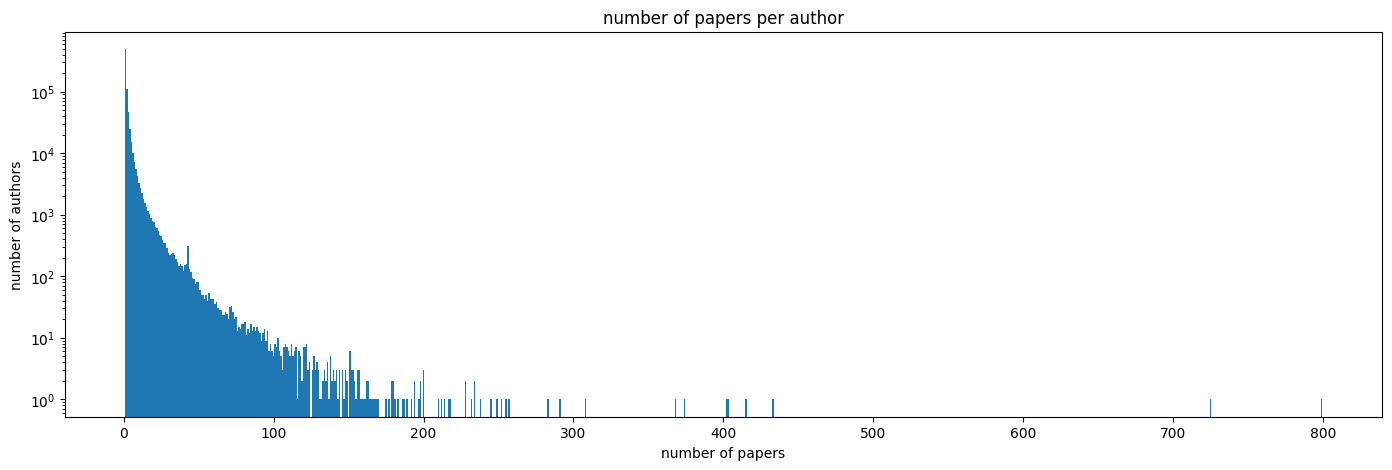

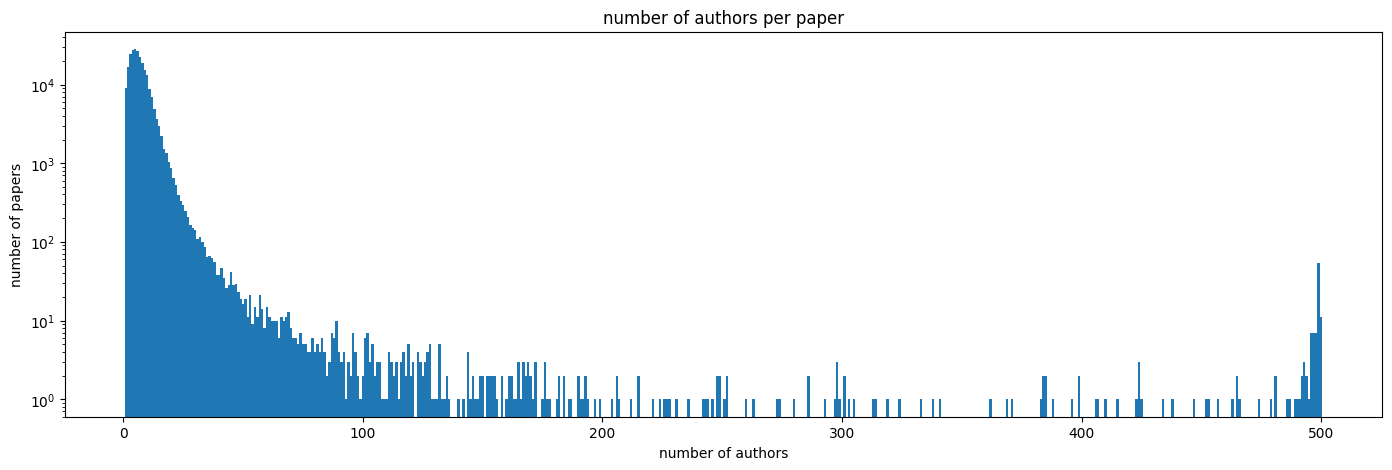

In [ ]:
papers_per_author = edges.groupby('author')['paper'].count()
authors_per_paper = edges.groupby('paper')['author'].count()

print('Paper with the most authors ({}):'.format(authors_per_paper.max()))
get_link(authors_per_paper.idxmax(), 'paper')

print('Author with the most papers ({}):'.format(papers_per_author.max()))
get_link(papers_per_author.idxmax(), 'author')

fig, ax = plt.subplots()
ax.hist(papers_per_author, bins=bins(papers_per_author), log=True);
ax.set_title('number of papers per author');
ax.set_xlabel('number of papers');
ax.set_ylabel('number of authors');

fig, ax = plt.subplots()
ax.hist(authors_per_paper, bins=bins(authors_per_paper), log=True);
ax.set_title('number of authors per paper');
ax.set_xlabel('number of authors');
ax.set_ylabel('number of papers');

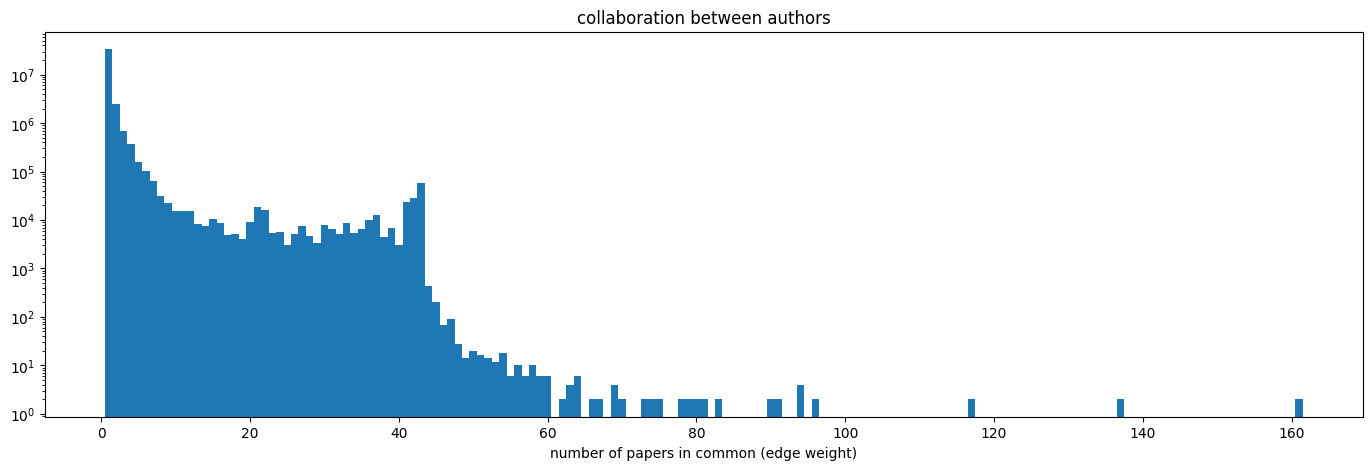

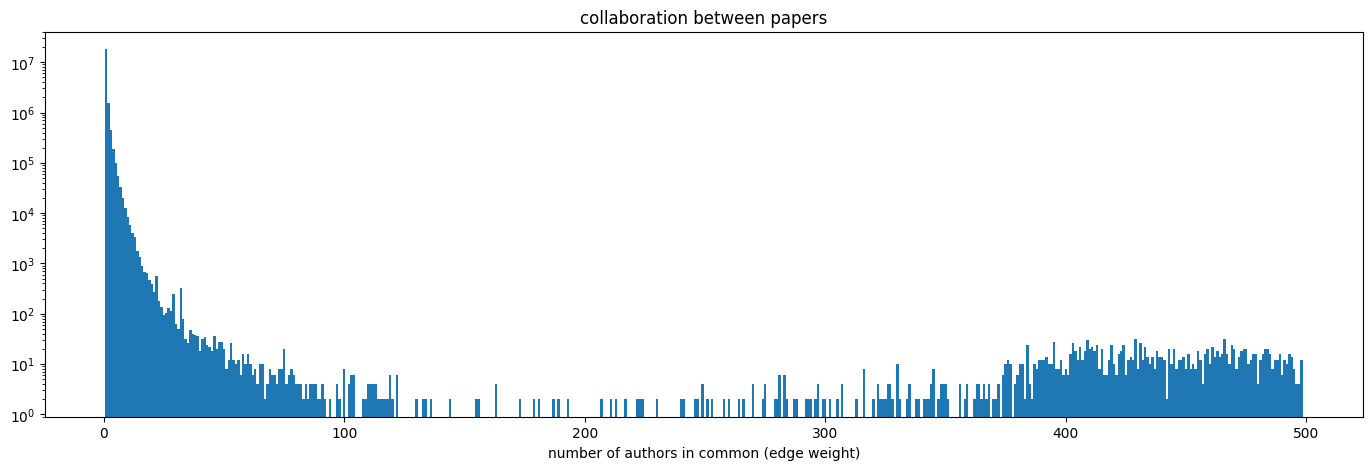

In [ ]:
fig, ax = plt.subplots()
ax.hist(adjacency_authors.data, bins=bins(adjacency_authors.data), log=True);
ax.set_title('collaboration between authors');
ax.set_xlabel('number of papers in common (edge weight)');

fig, ax = plt.subplots()
ax.hist(adjacency_papers.data, bins=bins(adjacency_papers.data), log=True);
ax.set_title('collaboration between papers');
ax.set_xlabel('number of authors in common (edge weight)');

## 3 Publication year

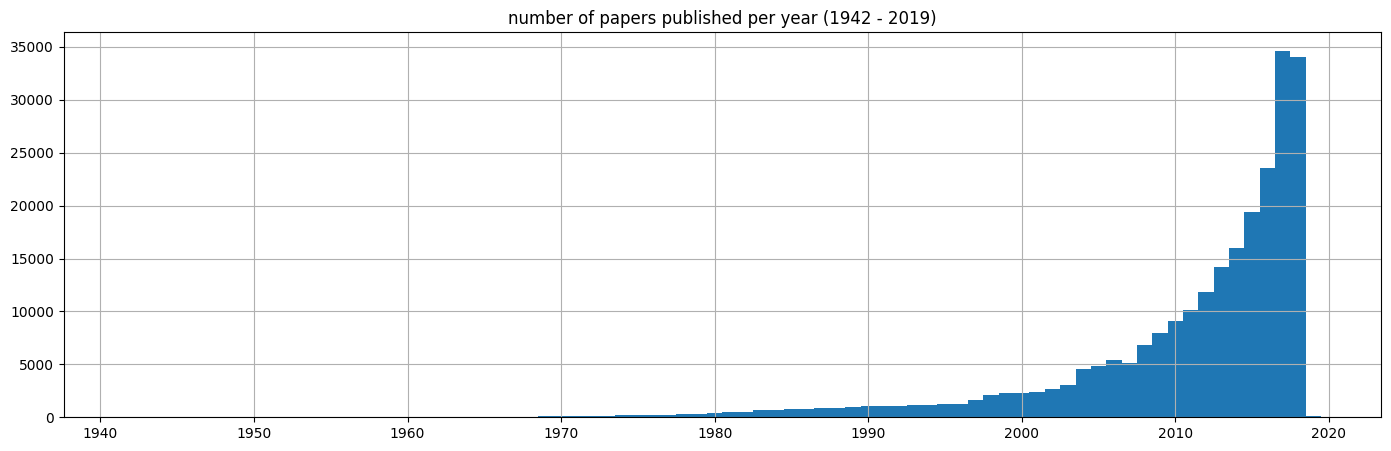

In [ ]:
ax = papers['year'].hist(bins=bins(papers['year']))
ax.set_title('number of papers published per year ({} - {})'.format(papers['year'].min(), papers['year'].max()));

## 4 Citations

In [ ]:
print('papers have at least {:,} citations (2019)'.format(papers['citations_2019'].min()))
print('papers have at most {:,} citations (2019)'.format(papers['citations_2019'].max()))
print('there are {:,} citations in total (2019)'.format(papers['citations_2019'].sum()))
print()

# print('authors have at least {:,} citations'.format(authors['citations_2019'].min()))
# print('authors have at most {:,} citations'.format(authors['citations_2019'].max()))
# print('there are {:,} in total'.format(authors['citations_2019'].sum()))
# print()

print('Most cited paper ({:,} citations):'.format(papers['citations_2019'].max()))
get_link(papers['citations_2019'].idxmax(), 'paper')

# print('Most cited author ({:,} citations):'.format(authors['citations_2019'].max()))
# get_link(authors['citations_2019'].idxmax(), 'author')

papers have at least 0 citations (2019)
papers have at most 234 citations (2019)
there are 443,283 citations in total (2019)

Most cited paper (234 citations):


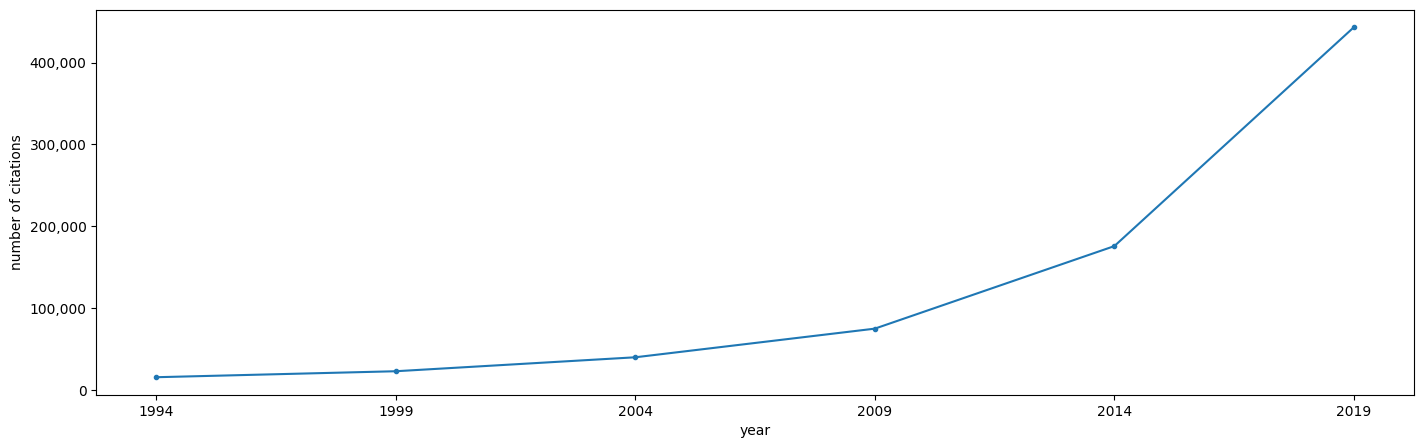

In [ ]:
years = [int(column[-4:]) for column in papers.columns if 'citations' in column[:-4]]
citations_per_year = np.zeros(len(years))
for i, year in enumerate(years):
    citations_per_year[i] = papers[f'citations_{year}'].sum()
fig, ax = plt.subplots()
ax.plot(years, citations_per_year, '.-')
ax.set_xticks(years)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('year')
ax.set_ylabel('number of citations');

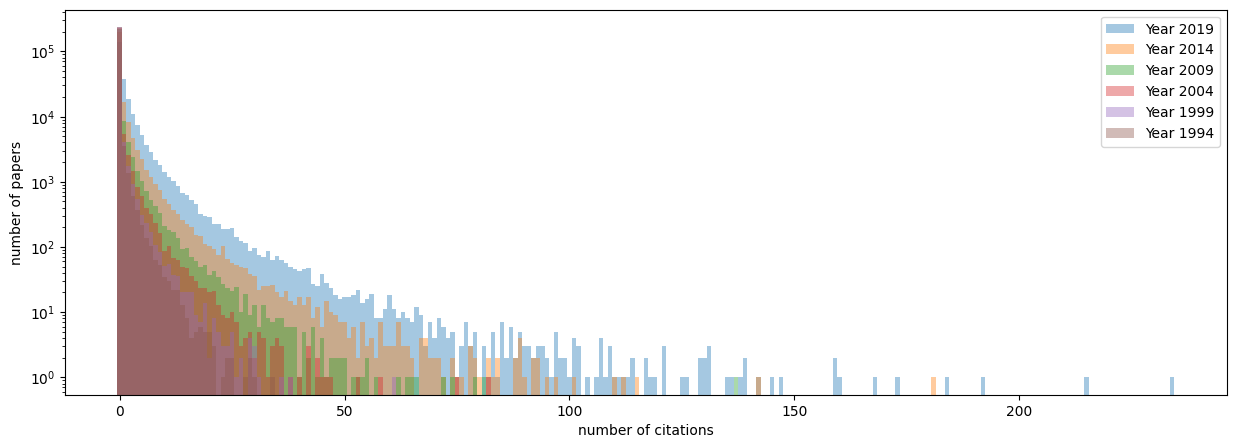

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
for year in years[::-1]:
    ax.hist(papers[f'citations_{year}'], bins=bins(papers['citations_2019']), log=True, label=f'Year {year}', alpha=0.4)
ax.set_xlabel('number of citations')
ax.set_ylabel('number of papers')
ax.legend();

## 5 References

In [ ]:
print('papers have at least {:,} references'.format(papers['references'].min()))
print('papers have at most {:,} references'.format(papers['references'].max()))

print('most referencing paper ({:,} references):'.format(papers['references'].max()))
get_link(papers['references'].idxmax(), 'paper')

papers have at least 1 references
papers have at most 5,558 references
most referencing paper (5,558 references):


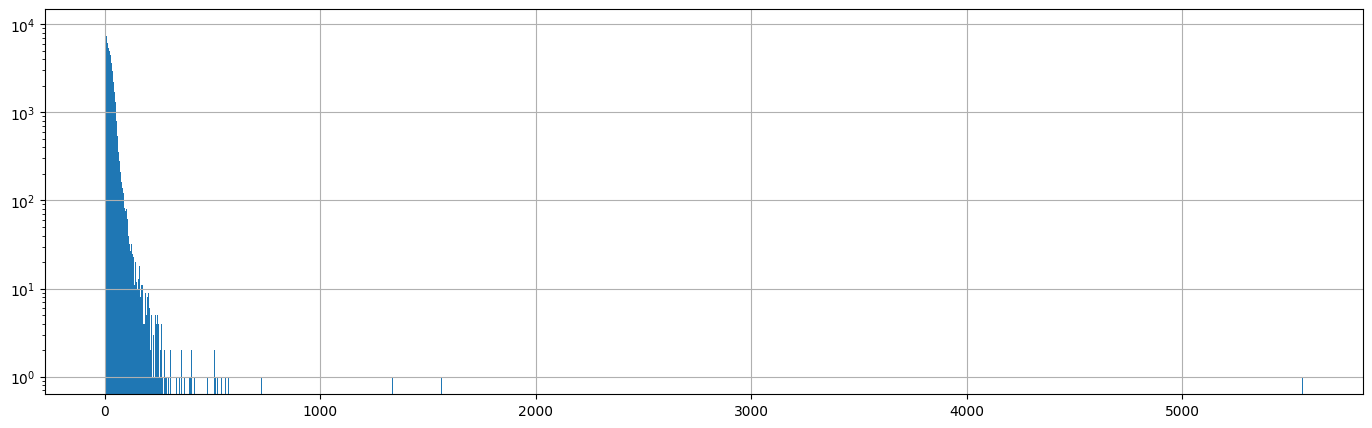

In [ ]:
papers['references'].hist(bins=bins(papers['references']), log=True);

## 6 Collaboration complex between authors

In [ ]:
dimension = len(simplices)
sizes = np.array([len(s) for s in simplices])

for k, size in enumerate(sizes):
    print(f'{size:,} {k}-simplices')
print('{:,} simplices in total'.format(np.sum(sizes)))

352 0-simplices
1,474 1-simplices
3,285 2-simplices
5,019 3-simplices
5,559 4-simplices
4,547 5-simplices
2,732 6-simplices
1,175 7-simplices
343 8-simplices
61 9-simplices
5 10-simplices
24,552 simplices in total


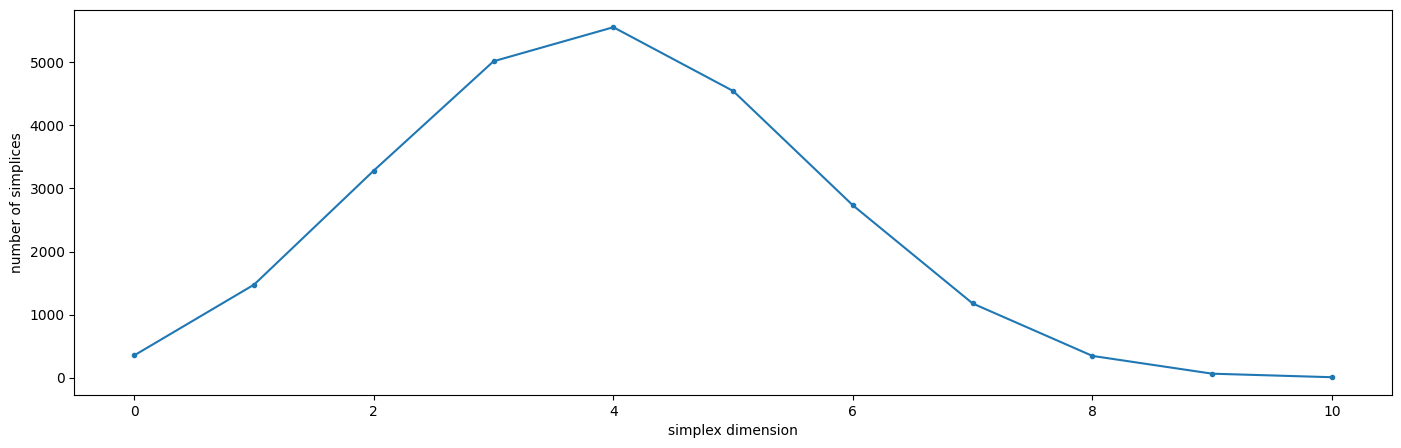

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(dimension), sizes, '.-')
ax.set_xlabel('simplex dimension')
ax.set_ylabel('number of simplices');

## 7 Operators (boundaries and Laplacians)

In [ ]:
for dim, boundary in enumerate(boundaries):
    print('{}-boundary matrix: {:,} x {:,}, {:,} non-zeros ({:.2%})'.format(
        dim+1, *boundary.shape, boundary.nnz, boundary.nnz/np.prod(boundary.shape)))

1-boundary matrix: 352 x 1,474, 2,948 non-zeros (0.57%)
2-boundary matrix: 1,474 x 3,285, 9,855 non-zeros (0.20%)
3-boundary matrix: 3,285 x 5,019, 20,076 non-zeros (0.12%)
4-boundary matrix: 5,019 x 5,559, 27,795 non-zeros (0.10%)
5-boundary matrix: 5,559 x 4,547, 27,282 non-zeros (0.11%)
6-boundary matrix: 4,547 x 2,732, 19,124 non-zeros (0.15%)
7-boundary matrix: 2,732 x 1,175, 9,400 non-zeros (0.29%)
8-boundary matrix: 1,175 x 343, 3,087 non-zeros (0.77%)
9-boundary matrix: 343 x 61, 610 non-zeros (2.92%)
10-boundary matrix: 61 x 5, 55 non-zeros (18.03%)


In [ ]:
def get_spectrum(laplacian, lowest=False, shift_invert=True):
    # Shift-invert mode is much faster, but can raise "factor is exactly singular".
    largest = sparse.linalg.eigsh(laplacian, k=1, which='LA', return_eigenvectors=False)
    if lowest:
        if shift_invert:
            lowest = sparse.linalg.eigsh(laplacian, k=1, sigma=0, which='LM', return_eigenvectors=False)
        else:
            lowest = sparse.linalg.eigsh(laplacian, k=1, which='SA', return_eigenvectors=False)
        return lowest[0], largest[0]
    else:
        return largest[0]

spectrums = [get_spectrum(laplacian) for laplacian in laplacians]

In [ ]:
for dim, (laplacian, spectrum) in enumerate(zip(laplacians, spectrums)):
    print('{}-simplices: {:,} simplices, {:.2%} sparse, spectrum in [0, {:.0f}]'.format(
        dim, laplacian.shape[0], laplacian.nnz/np.prod(laplacian.shape), spectrum))
    assert laplacian.shape == (len(simplices[dim]), len(simplices[dim]))

0-simplices: 352 simplices, 2.66% sparse, spectrum in [0, 117]
1-simplices: 1,474 simplices, 1.17% sparse, spectrum in [0, 117]
2-simplices: 3,285 simplices, 0.04% sparse, spectrum in [0, 24]
3-simplices: 5,019 simplices, 0.02% sparse, spectrum in [0, 16]
4-simplices: 5,559 simplices, 0.02% sparse, spectrum in [0, 14]
5-simplices: 4,547 simplices, 0.02% sparse, spectrum in [0, 11]
6-simplices: 2,732 simplices, 0.04% sparse, spectrum in [0, 11]
7-simplices: 1,175 simplices, 0.09% sparse, spectrum in [0, 11]
8-simplices: 343 simplices, 0.29% sparse, spectrum in [0, 11]
9-simplices: 61 simplices, 1.64% sparse, spectrum in [0, 11]
10-simplices: 5 simplices, 20.00% sparse, spectrum in [0, 11]


## 8 Signals (cochains) on collaboration complex

In [ ]:
# Rayleigh quotient between every pair of signals (for all dimensions).
n_features = features[0].shape[1]
rayleigh = np.empty((len(features), n_features, n_features))
for dim in range(len(features)):
    rayleigh[dim] = features[dim].T @ laplacians[dim] @ features[dim]
    # Division by zero will occur if a signal is all zeros.
    rayleigh[dim] /= features[dim].T @ features[dim]

Which signals are "smooth"?

In [ ]:
# Rayleigh quotient between every pair of signals (for all dimensions).
n_features = features[0].shape[1]
rayleigh2 = np.empty((len(features), n_features, n_features))
for dim in range(len(features)):
    rayleigh2[dim] = features[dim].T @ laplacians[dim] @ features[dim]
    print(rayleigh2)
    print("-------------")
    # Division by zero will occur if a signal is all zeros.
    rayleigh2[dim] /= features[dim].T @ features[dim]
print(laplacians.shape)
rayleigh2*= 1/2
# print(len(features[0]))
# print(rayleigh2)
rayleigh2+= np.identity(len(features))
rayleigh= np.inverse(rayleigh)

[[[6.458052e+06]]

 [[1.000000e+00]]

 [[2.000000e+00]]

 [[3.000000e+00]]

 [[4.000000e+00]]

 [[5.000000e+00]]

 [[6.000000e+00]]

 [[7.000000e+00]]

 [[8.000000e+00]]

 [[9.000000e+00]]

 [[1.000000e+01]]]
-------------
[[[2.77416074e+01]]

 [[4.80355200e+06]]

 [[2.00000000e+00]]

 [[3.00000000e+00]]

 [[4.00000000e+00]]

 [[5.00000000e+00]]

 [[6.00000000e+00]]

 [[7.00000000e+00]]

 [[8.00000000e+00]]

 [[9.00000000e+00]]

 [[1.00000000e+01]]]
-------------
[[[2.77416074e+01]]

 [[1.15878639e+01]]

 [[5.61862800e+06]]

 [[3.00000000e+00]]

 [[4.00000000e+00]]

 [[5.00000000e+00]]

 [[6.00000000e+00]]

 [[7.00000000e+00]]

 [[8.00000000e+00]]

 [[9.00000000e+00]]

 [[1.00000000e+01]]]
-------------
[[[2.77416074e+01]]

 [[1.15878639e+01]]

 [[7.94437579e+00]]

 [[7.24612700e+06]]

 [[4.00000000e+00]]

 [[5.00000000e+00]]

 [[6.00000000e+00]]

 [[7.00000000e+00]]

 [[8.00000000e+00]]

 [[9.00000000e+00]]

 [[1.00000000e+01]]]
-------------
[[[2.77416074e+01]]

 [[1.15878639e+01]]



ValueError: ignored

In [ ]:
# Rayleigh quotient between every pair of signals (for all dimensions).
n_features = features[0].shape[1]
rayleigh3 = np.empty((len(features), n_features, n_features))
print(rayleigh3)
# for dim in range(len(features)):
rayleigh3 =  np.linalg.inv(np.identity(352)+(1/2)*laplacians[0])
# print(rayleigh3)
# print("-------")
# print(rayleigh)
    # Division by zero will occur if a signal is all zeros.
# rayleigh3[dim] /= features[dim].T @ features[dim]

In [ ]:
# Rayleigh quotient between every pair of signals (for all dimensions).
n_features = features[0].shape[1]
rayleigh4 = np.empty((len(features), n_features, n_features))
for dim in range(len(features)):
  if dim==1:
    # rayleigh4[dim]=np.linalg.inv(np.identity(1474)+(1/2)*laplacians[dim])
    rayleigh4[dim]=features[dim].T @ np.linalg.inv(np.identity(1474)+(1/2)*laplacians[dim]) @ features[dim]
  else:
    rayleigh4[dim] = features[dim].T @ laplacians[dim] @ features[dim]
    # Division by zero will occur if a signal is all zeros.
  rayleigh4[dim] /= features[dim].T @ features[dim]

In [ ]:
for dim in range(len(features)):
  print(rayleigh[dim],'--->',rayleigh4[dim])

In [ ]:
#columns = ['citations_1994', 'citations_1999', 'citations_2004', 'citations_2009', 'citations_2014', 'citations_2019', 'references', 'year']
columns=['citations_2019']
fig, ax = plt.subplots()
ax.set_title('smoothness of signals')
ax.set_ylabel('Rayleigh quotient')
ax.set_xlabel("signal's name")
ax.semilogy(np.array([np.diag(r) for r in rayleigh]).T, 'o-')
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns)
ax.legend([f'{dim}-cochains ($\lambda_{{max}} = {spectrums[dim]:.0f}$)' for dim in range(len(features))], loc='lower left')
fig.tight_layout();
#fig.savefig('smoothness.pdf');

Does a signal explain another?

In [ ]:
fig, axes = plt.subplots(1, len(rayleigh))
for dim, (r, ax) in enumerate(zip(rayleigh, axes)):
    im = ax.imshow(r)
    ax.set_title(f'dimension {dim}')

## 9 Laplacians' spectra (and Fourier transform)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(laplacians[0].toarray())

The spectrum of the 0-Laplacian has a couple of very high eigenvalues.

In [ ]:
plt.plot(eigenvalues);
print(eigenvalues[:10])

Some eigenvalues have high multiplicity. Probably due to the connected cliques formed by the higher-dimensional simplices.

In [ ]:
plt.plot(eigenvalues[:-100]);

In [ ]:
multiplicities = [np.sum(eigenvalues == e) for e in range(20)]

fig, ax = plt.subplots()
ax.plot(multiplicities, 'o-')
ax.set_xticks(range(len(multiplicities)))
ax.set_title('eigenvalue multiplicities') #Wi
ax.set_ylabel('muliplicity')
ax.set_xlabel('eigenvalue');

Fourier transform of 0-cochains. Their spectral content should tell how smooth they are.

In [ ]:
fourier = eigenvectors.T @ (features[0] / np.linalg.norm(features[0], axis=0))

In [ ]:
idx_max = -100

plt.semilogy(eigenvalues[:idx_max], np.abs(fourier)[:idx_max], '.', alpha=0.8)
plt.legend(columns);

In [ ]:
%cd /content/simplicial_neural_networks
!python ./experiments/impute_citations.py ./data/s2_3_collaboration_complex ./experiments/output 150250 30

/content/simplicial_neural_networks
Parameter counts:
150
30
4500
30
150
1
150
30
4500
30
150
1
150
30
4500
30
150
1
Total number of parameters: 14583
[0.6988636363636364, 0.6994572591587517, 0.6998477929984779]


In [ ]:
from google.colab import files
files.download("/content/simplicial_neural_networks/experiments/output")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
%cd /content/simplicial_neural_networks/experiments/output
shutil.make_archive('new', 'zip', 'output')

/content/simplicial_neural_networks/experiments/output


'/content/simplicial_neural_networks/experiments/output/new.zip'

In [ ]:
c=0
for filename in os.listdir(folder_path):
  c+=1
print(c)

6304


In [ ]:
#calculating accuracy for the 0-laplacian

import os
import numpy as np
from sklearn.metrics import accuracy_score

folder_path = '/content/simplicial_neural_networks/experiments/output'

files = os.listdir(folder_path)
files.sort()

prediction = []
actual = []

counter=0

for filename in os.listdir('.'):
    if filename.startswith('prediction') and filename.endswith('0.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        prediction += numbers_int
        counter+=1
    elif filename.startswith('actual') and filename.endswith('0.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        actual += numbers_int
prediction = [round(x, 0) for x in prediction]
actual = [round(x, 0) for x in actual]

print(counter)
accuracy = accuracy_score(actual, prediction)
print(f'Accuracy: {accuracy}')

1000
Accuracy: 0.6454959349593496


In [ ]:
#calculating accuracy for the 0-laplacian

import os
import numpy as np
from sklearn.metrics import accuracy_score

folder_path = '/content/simplicial_neural_networks/experiments/output'

files = os.listdir(folder_path)
files.sort()

prediction = []
actual = []

counter=0

for filename in os.listdir('.'):
    if filename.startswith('prediction') and filename.endswith('1.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        prediction += numbers_int
        counter+=1
    elif filename.startswith('actual') and filename.endswith('1.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        actual += numbers_int
prediction = [round(x, 0) for x in prediction]
actual = [round(x, 0) for x in actual]

print(counter)
accuracy = accuracy_score(actual, prediction)
print(f'Accuracy: {accuracy}')

1000
Accuracy: 0.6508690591658584


In [ ]:
#calculating accuracy for the 0-laplacian

import os
import numpy as np
from sklearn.metrics import accuracy_score

folder_path = '/content/simplicial_neural_networks/experiments/output'

files = os.listdir(folder_path)
files.sort()

prediction = []
actual = []

counter=0

for filename in os.listdir('.'):
    if filename.startswith('prediction') and filename.endswith('2.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        prediction += numbers_int
        counter+=1
    elif filename.startswith('actual') and filename.endswith('2.txt'):
        with open(filename, 'r') as f:
            numbers_str = f.read()
        numbers_list = numbers_str.split()
        numbers_int = list(map(float, numbers_list))
        actual += numbers_int
prediction = [round(x, 0) for x in prediction]
actual = [round(x, 0) for x in actual]

print(counter)
accuracy = accuracy_score(actual, prediction)
print(f'Accuracy: {accuracy}')

1000
Accuracy: 0.6752018268812527
